**Dataset** **Creation**

In [4]:
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaTutorial") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")

Spark and Delta Lake are ready!


In [5]:
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing", 1, 50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]

df = spark.createDataFrame(data, columns)

# Save as Delta Table
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

**1. Managed vs Unmanaged Tables**

Task:

Create a managed table orders_managed from /tmp/orders_delta

Create an unmanaged table orders_unmanaged pointing to the same location

In [15]:
# Managed table
spark.sql("""
DROP TABLE IF EXISTS orders_managed
""")

spark.sql("""
CREATE TABLE orders_managed
USING DELTA
AS SELECT * FROM delta.`/tmp/orders_delta`
""")


# Unmanaged table
spark.sql("""
DROP TABLE IF EXISTS orders_unmanaged
""")
spark.sql("""
CREATE TABLE orders_unmanaged
USING DELTA
LOCATION '/tmp/orders_delta'
""")

# Verify
spark.sql("SHOW TABLES").show()


+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|  orders_managed|      false|
|  default|orders_unmanaged|      false|
+---------+----------------+-----------+



In [16]:
spark.sql("DESCRIBE EXTENDED orders_managed").show(truncate=False)
spark.sql("DESCRIBE EXTENDED orders_unmanaged").show(truncate=False)


+----------------------------+---------------------------------------------------+-------+
|col_name                    |data_type                                          |comment|
+----------------------------+---------------------------------------------------+-------+
|order_id                    |bigint                                             |NULL   |
|customer_name               |string                                             |NULL   |
|category                    |string                                             |NULL   |
|quantity                    |bigint                                             |NULL   |
|amount                      |bigint                                             |NULL   |
|                            |                                                   |       |
|# Detailed Table Information|                                                   |       |
|Name                        |spark_catalog.default.orders_managed               |       |

**2. CRUD Operations**

Task:

Read from the table

Update all "Clothing" category orders to have amount = amount + 20

Delete all orders with quantity < 2

Merge in a new dataset (new orders & updated orders)


In [7]:
# Read table
spark.read.format("delta").load("/tmp/orders_delta").show()

# Update "Clothing" category orders -> amount + 20
spark.sql("""
UPDATE delta.`/tmp/orders_delta`
SET amount = amount + 20
WHERE category = 'Clothing'
""")

# Delete orders with quantity < 2
spark.sql("""
DELETE FROM delta.`/tmp/orders_delta`
WHERE quantity < 2
""")

# Merge new data (new + updated)
from delta.tables import DeltaTable

deltaTable = DeltaTable.forPath(spark, "/tmp/orders_delta")

new_data = [
    (3, "Mike", "Electronics", 4, 650),  # updated amount
    (5, "Liam", "Clothing", 2, 90),      # new order
]
new_df = spark.createDataFrame(new_data, columns)

deltaTable.alias("old").merge(
    new_df.alias("new"),
    "old.order_id = new.order_id"
).whenMatchedUpdateAll() \
 .whenNotMatchedInsertAll() \
 .execute()

# Check result
spark.read.format("delta").load("/tmp/orders_delta").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|   Clothing|       2|    90|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



**3. History & Time Travel**

Task:

Use DESCRIBE HISTORY to check previous versions

Read data from version 0 and compare with the latest version


In [8]:
# Show history
spark.sql("DESCRIBE HISTORY delta.`/tmp/orders_delta`").show(truncate=False)

# Read from version 0
version0_df = spark.read.format("delta").option("versionAsOf", 0).load("/tmp/orders_delta")
print("Version 0:")
version0_df.show()

# Read latest
latest_df = spark.read.format("delta").load("/tmp/orders_delta")
print("Latest Version:")
latest_df.show()


+-------+-----------------------+------+--------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|ve

**4. Incremental Load Pattern**

Task:

Create a new mini-batch with only new orders (IDs 5 & 6)

Append to the Delta table

Show final result

In [9]:
# New mini-batch
new_orders = [
    (6, "Emma", "Electronics", 1, 150),
    (7, "Olivia", "Clothing", 5, 300),
]
new_orders_df = spark.createDataFrame(new_orders, columns)

# Append
new_orders_df.write.format("delta").mode("append").save("/tmp/orders_delta")

# Final table
spark.read.format("delta").load("/tmp/orders_delta").show()


+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|   Clothing|       2|    90|
|       1|         John|Electronics|       2|   300|
|       6|         Emma|Electronics|       1|   150|
|       7|       Olivia|   Clothing|       5|   300|
+--------+-------------+-----------+--------+------+



**5. Simple Streaming Read**

Task:

Read the /tmp/orders_delta in streaming mode

Output to console every 5 seconds

In [14]:
# Streaming read (will keep printing every 5s)
stream_df = spark.readStream.format("delta").load("/tmp/orders_delta")

query = (
    stream_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

# Wait for a short period to demonstrate
import time
time.sleep(15)
query.stop()


**6. Visualization**

Task:

Read Delta table into Pandas

Create a bar chart of category vs total amount


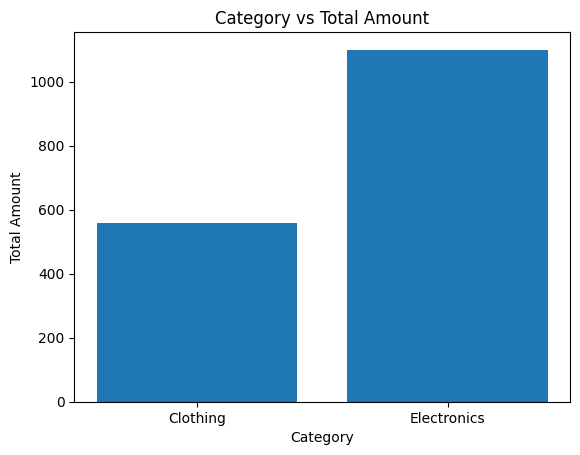

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Read Delta into Pandas
pdf = spark.read.format("delta").load("/tmp/orders_delta").toPandas()

# Group & plot
category_amount = pdf.groupby("category")["amount"].sum()

plt.bar(category_amount.index, category_amount.values)
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()
